- Dataset taken from: https://www.kaggle.com/datasets/sulianova/cardiovascular-disease-dataset/data
- Goal is to try to predict if a person is likely to have cardiovascular disease based on the best performing features. To achieve this primary goal, the notebook performs data processing, exploratory data analysis, and data modeling.
- I would like to find out what is the distribution of the various features in the dataset. Moreover, I would like to find which features have the highest explanatory power.

Features in the dataset:

- age | int (days)
- height | int (cm)
- weight | float (kg)
- gender | categorical code
- Systolic blood pressure (ap_hi) | int
- Diastolic blood pressure (ap_lo) | int
- cholesterol | 1: normal, 2: above normal, 3: well above normal
- Glucose (gluc) | 1: normal, 2: above normal, 3: well above normal
- Smoking (smoke) | binary
- Alcohol intake (alco) | binary
- Physical activity (active) | binary
- Presence or absence of cardiovascular disease (cardio) | binary

In [1]:
# Importing necessary library
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from scipy.special import expit  # Sigmoid function
from scipy.stats import pointbiserialr
from scipy.stats import chi2_contingency

In [2]:
df = pd.read_csv('data.csv', sep=';')

print("First 5 rows of the dataset:")
print(df.head())

# Calculate the number of missing values for each column
# This identifies any columns with incomplete data
missing_values = df.isna().sum()

# Display the missing values per column
print("\nNumber of missing values for each column:")
print(missing_values)


First 5 rows of the dataset:
    id      age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  \
0  0.0  18393.0     2.0   168.0    62.0  110.0   80.0          1.0   1.0   
1  1.0  20228.0     1.0   156.0    85.0  140.0   90.0          3.0   1.0   
2  2.0  18857.0     1.0   165.0    64.0  130.0   70.0          3.0   1.0   
3  3.0  17623.0     2.0   169.0    82.0  150.0  100.0          1.0   1.0   
4  4.0  17474.0     1.0   156.0    56.0  100.0   60.0          1.0   1.0   

   smoke  alco  active  cardio  
0    0.0   NaN     1.0     0.0  
1    0.0   0.0     1.0     1.0  
2    0.0   0.0     0.0     1.0  
3    0.0   0.0     1.0     1.0  
4    0.0   0.0     0.0     0.0  

Number of missing values for each column:
id             2086
age            2051
gender         2094
height         2148
weight         2109
ap_hi          2050
ap_lo          2124
cholesterol    2160
gluc           2021
smoke          2029
alco           2099
active         2131
cardio         2070
dtype: int64


- The number of missing values in each column is divided by the total number of rows to calculate the percentage of missing values.
- Rows with missing values are removed using dropna(). This approach is chosen because the percentage of missing values is low (<3%), making it reasonable to remove these rows rather than impute values, which could introduce bias or inaccuracies.
- Removing rows is less likely to affect the overall dataset compared to imputing values.

In [3]:
# Calculate the percentage of missing values for each column
# Divide the number of missing values by the total number of rows
total_rows = len(df)
missing_percentage = (df.isna().sum() / total_rows) * 100

# Display the percentage of missing values for each column
print("\nPercentage of missing values for each column:")
print(missing_percentage)

# Remove rows with missing values
# Since the percentage of missing values is less than 3% for each column,
df_cleaned = df.dropna()

# Display the shape of the cleaned DataFrame to confirm removal
print("\nShape of the dataset after removing rows with missing values:")
print(df_cleaned.shape)




Percentage of missing values for each column:
id             2.980000
age            2.930000
gender         2.991429
height         3.068571
weight         3.012857
ap_hi          2.928571
ap_lo          3.034286
cholesterol    3.085714
gluc           2.887143
smoke          2.898571
alco           2.998571
active         3.044286
cardio         2.957143
dtype: float64

Shape of the dataset after removing rows with missing values:
(47183, 13)


- I removed outliers in the ap_hi (systolic blood pressure) and ap_lo (diastolic blood pressure) columns.
- Rows where ap_hi or ap_lo values exceed 3 standard deviations from their means are considered outliers and excluded.
- This step helps clean the data and ensures histograms are not distorted by extreme values.

In [4]:
# Step: Remove outliers for 'ap_hi' and 'ap_lo'
# Calculate mean and standard deviation for 'ap_hi' and 'ap_lo'
mean_ap_hi, std_ap_hi = df_cleaned['ap_hi'].mean(), df_cleaned['ap_hi'].std()
mean_ap_lo, std_ap_lo = df_cleaned['ap_lo'].mean(), df_cleaned['ap_lo'].std()

# Identify rows to keep: within 3 standard deviations of the mean
condition_ap_hi = (df_cleaned['ap_hi'] >= mean_ap_hi - 3 * std_ap_hi) & (df_cleaned['ap_hi'] <= mean_ap_hi + 3 * std_ap_hi)
condition_ap_lo = (df_cleaned['ap_lo'] >= mean_ap_lo - 3 * std_ap_lo) & (df_cleaned['ap_lo'] <= mean_ap_lo + 3 * std_ap_lo)

# Apply conditions to filter the dataset
df_cleaned = df_cleaned[condition_ap_hi & condition_ap_lo]

# Display the shape of the cleaned dataset to confirm outlier removal
print(f"Shape of the dataset after removing outliers: {df_cleaned.shape}")


Shape of the dataset after removing outliers: (46531, 13)


- I converted the age column from days to years by dividing the values by 365.
- Since the original age in days is no longer needed, I replaced the age column with the converted values directly. This simplifies the dataset.

In [5]:
# I use .loc to avoid the SettingWithCopyWarning and replace the 'age' column
df_cleaned.loc[:, 'age'] = df_cleaned['age'] / 365

# Display the first 5 rows to verify the conversion
print("\nFirst 5 rows of the dataset with 'age' column converted to years:")
print(df_cleaned.head())


First 5 rows of the dataset with 'age' column converted to years:
    id        age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  \
1  1.0  55.419178     1.0   156.0    85.0  140.0   90.0          3.0   1.0   
2  2.0  51.663014     1.0   165.0    64.0  130.0   70.0          3.0   1.0   
3  3.0  48.282192     2.0   169.0    82.0  150.0  100.0          1.0   1.0   
4  4.0  47.873973     1.0   156.0    56.0  100.0   60.0          1.0   1.0   
6  9.0  60.583562     1.0   157.0    93.0  130.0   80.0          3.0   1.0   

   smoke  alco  active  cardio  
1    0.0   0.0     1.0     1.0  
2    0.0   0.0     0.0     1.0  
3    0.0   0.0     1.0     1.0  
4    0.0   0.0     0.0     0.0  
6    0.0   0.0     1.0     0.0  


- I created a bar plot to visualize the distribution of the target variable cardio, which is a binary random variable showing 1 for an individual who has heart disease, vs 0 for an individual who doesn't have heart disease.
- The plot shows the count of individuals with (1) and without (0) heart disease.

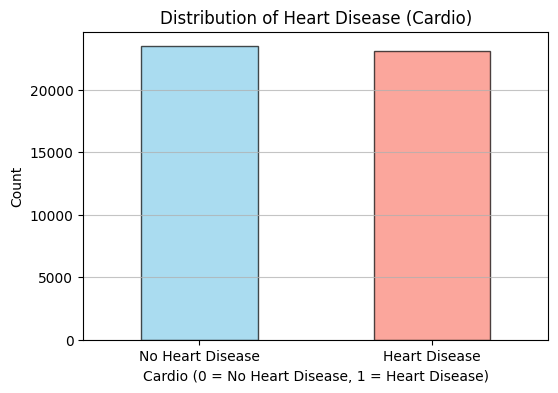

In [6]:
# Step: Plot the bar graph for the 'cardio' column
plt.figure(figsize=(6, 4))

# Calculate the counts of 0s and 1s in the 'cardio' column
df_cleaned['cardio'].value_counts().sort_index().plot(
    kind='bar', 
    color=['skyblue', 'salmon'], 
    edgecolor='black', 
    alpha=0.7
)

# Add title and labels
plt.title('Distribution of Heart Disease (Cardio)')
plt.xlabel('Cardio (0 = No Heart Disease, 1 = Heart Disease)')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['No Heart Disease', 'Heart Disease'], rotation=0)
plt.grid(axis='y', alpha=0.75)

# Show the plot
plt.show()


The split of individuals with and without heart disease is roughly even.

- I am plotting histograms for age, height, and weight to compare the distributions between individuals with heart disease (cardio = 1) and without heart disease (cardio = 0).
- Each plot has two histograms overlaid, one for each group, with transparent colors for better visibility.

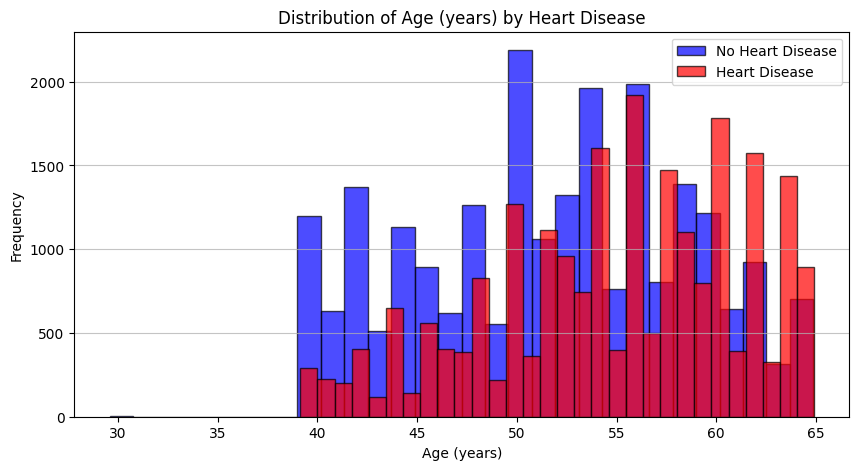

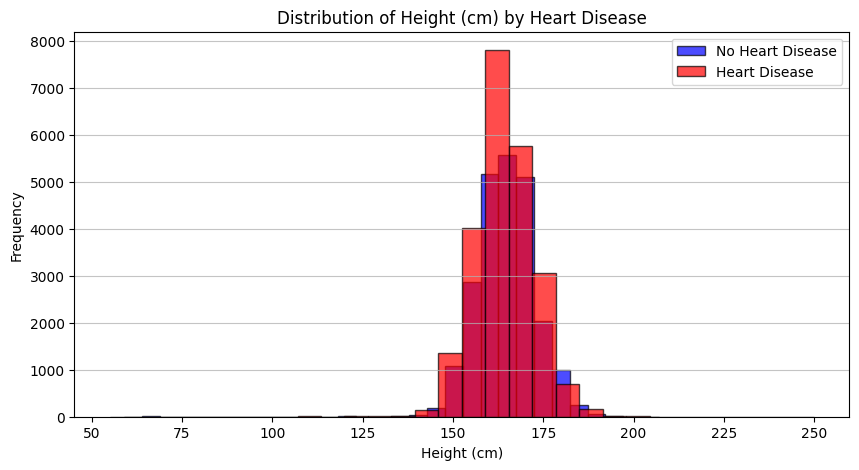

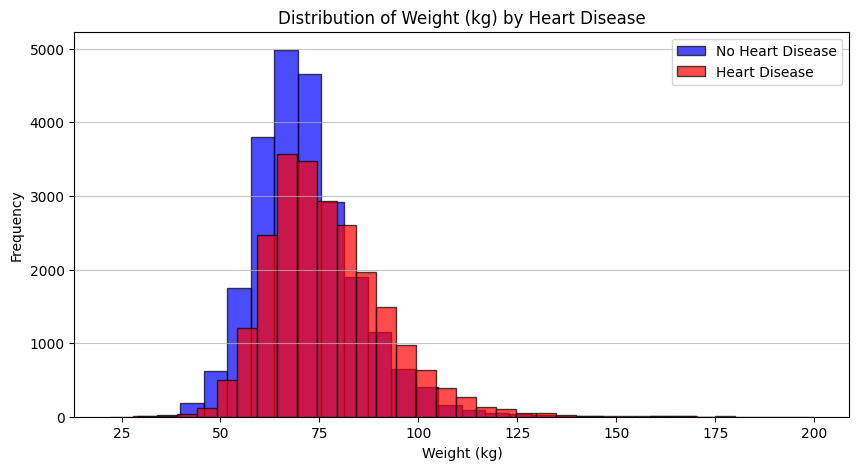

In [7]:
# Define the features to plot and their labels
features = ['age', 'height', 'weight']
labels = ['Age (years)', 'Height (cm)', 'Weight (kg)']

# Create histograms for each feature
for feature, label in zip(features, labels):
    plt.figure(figsize=(10, 5))
    
    # Plot histogram for individuals without heart disease (cardio = 0)
    plt.hist(df_cleaned[df_cleaned['cardio'] == 0][feature], bins=30, alpha=0.7, label='No Heart Disease', color='blue', edgecolor='black')
    
    # Plot histogram for individuals with heart disease (cardio = 1)
    plt.hist(df_cleaned[df_cleaned['cardio'] == 1][feature], bins=30, alpha=0.7, label='Heart Disease', color='red', edgecolor='black')
    
    # Add titles and labels
    plt.title(f'Distribution of {label} by Heart Disease')
    plt.xlabel(label)
    plt.ylabel('Frequency')
    plt.legend(loc='upper right')
    plt.grid(axis='y', alpha=0.75)
    
    # Show the plot
    plt.show()


As expected, weight and height are approximately normally distributed, while age has a left skewed distribution and consists mostly of individuals in the age range 40 to 65. Findings:
- There is a higher percentage of adults who are older with heart disease as compared to the population of younger adults.
- Height seems to not not be vastly different between individuals with heart disease and individuals with no heart disease.
- Weight seems on average to be higher for individuals with heart disease than for individuals without heart disease.

- I am plotting side-by-side histograms for the ap_hi (systolic blood pressure) and ap_lo (diastolic blood pressure) columns.
- These histograms compare the distributions for individuals with heart disease (cardio = 1) and without heart disease (cardio = 0).
- This helps visualize whether blood pressure levels differ significantly between the two groups.

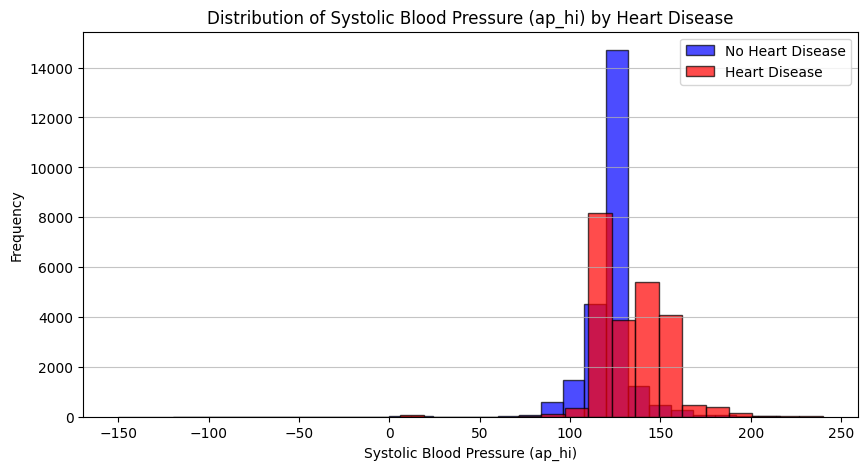

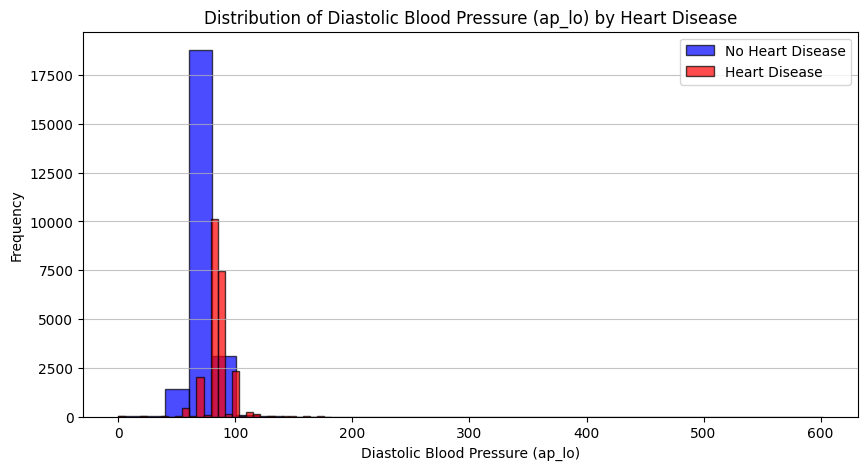

In [8]:
# Define the features to plot and their labels
features = ['ap_hi', 'ap_lo']
labels = ['Systolic Blood Pressure (ap_hi)', 'Diastolic Blood Pressure (ap_lo)']

# Create histograms for each feature
for feature, label in zip(features, labels):
    plt.figure(figsize=(10, 5))
    
    # Plot histogram for individuals without heart disease (cardio = 0)
    plt.hist(df_cleaned[df_cleaned['cardio'] == 0][feature], bins=30, alpha=0.7, label='No Heart Disease', color='blue', edgecolor='black')
    
    # Plot histogram for individuals with heart disease (cardio = 1)
    plt.hist(df_cleaned[df_cleaned['cardio'] == 1][feature], bins=30, alpha=0.7, label='Heart Disease', color='red', edgecolor='black')
    
    # Add titles and labels
    plt.title(f'Distribution of {label} by Heart Disease')
    plt.xlabel(label)
    plt.ylabel('Frequency')
    plt.legend(loc='upper right')
    plt.grid(axis='y', alpha=0.75)
    
    # Show the plot
    plt.show()


Findings from above charts:
- Clearly systolic blood pressure is much higher for individuals who have heart disease as opposed to individuals who don't.
- Similarly for diastolic blood pressure, a higher number of individuals with heart disease have disproportionately higher blood pressure.

- I am plotting bar charts for the binary variables smoke, alco, and active. These charts display the counts for each category (0 and 1).
- Bar plots are suitable for binary variables because they clearly show how many observations fall into each category.


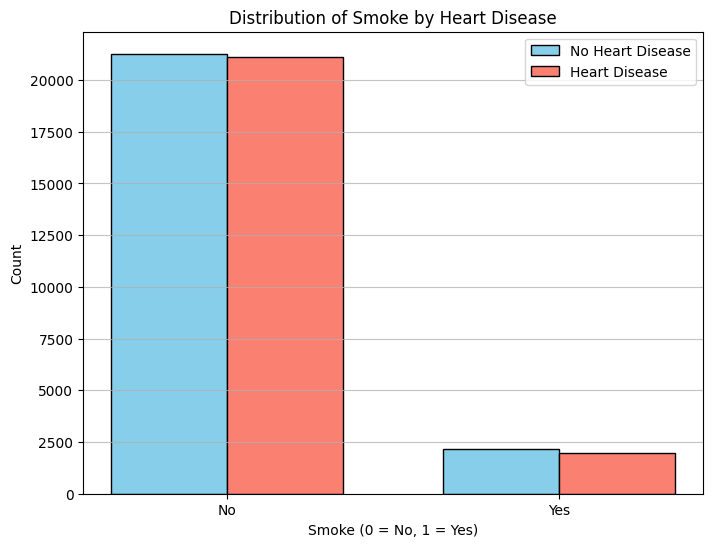

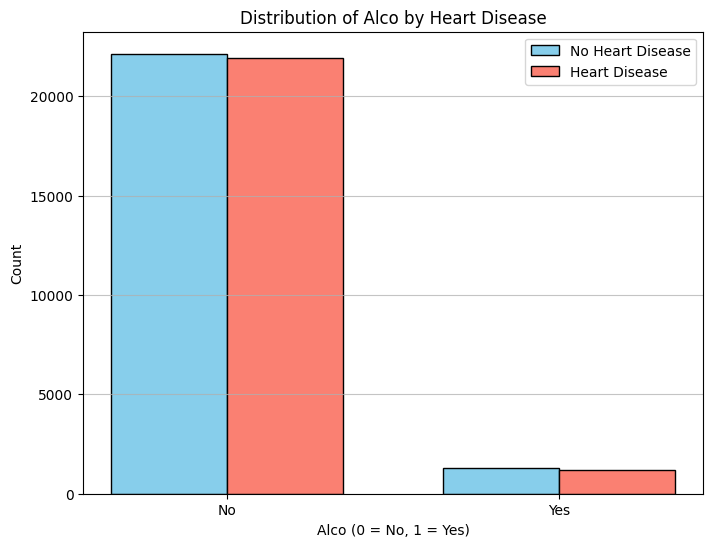

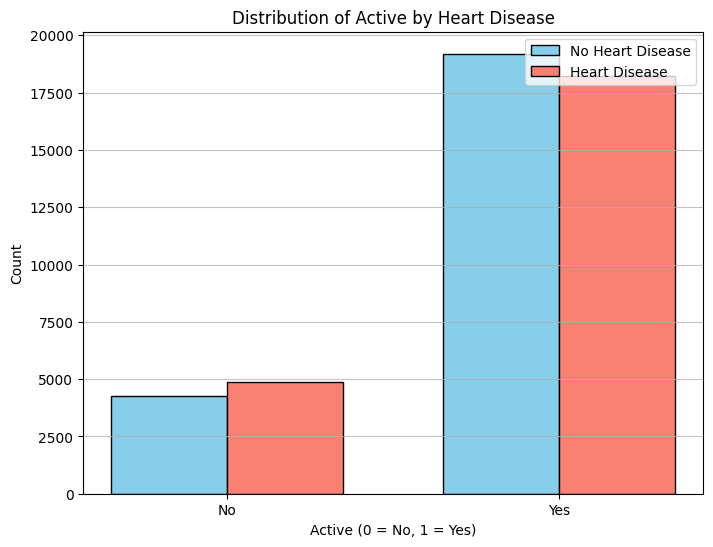

In [9]:
# I use bar plots to visualize the counts of 0 and 1 for each binary variable

binary_features = ['smoke', 'alco', 'active']

for feature in binary_features:
    plt.figure(figsize=(8, 6))
    
    # Calculate counts for each group
    counts_no_disease = df_cleaned[df_cleaned['cardio'] == 0][feature].value_counts().sort_index()
    counts_disease = df_cleaned[df_cleaned['cardio'] == 1][feature].value_counts().sort_index()
    
    # Set bar positions
    bar_width = 0.35
    x = np.arange(len(counts_no_disease))  # x-axis positions for bars
    
    # Plot bars
    plt.bar(x - bar_width/2, counts_no_disease, width=bar_width, label='No Heart Disease', color='skyblue', edgecolor='black')
    plt.bar(x + bar_width/2, counts_disease, width=bar_width, label='Heart Disease', color='salmon', edgecolor='black')
    
    # Add labels and title
    plt.title(f'Distribution of {feature.capitalize()} by Heart Disease')
    plt.xlabel(f'{feature.capitalize()} (0 = No, 1 = Yes)')
    plt.ylabel('Count')
    plt.xticks(ticks=x, labels=['No', 'Yes'])
    plt.legend(loc='upper right')
    plt.grid(axis='y', alpha=0.75)
    
    # Show the plot
    plt.show()


Findings:
- Interestingly, the distribution of smokers/non-smokers, alcohol users is similar between individiduals who have heart disease and those who don't. 
- It does seem that the number of individuals who are active is tilted towards individuals who don't have heart disease, although I would expect this number to be higher. As in, a higher number of people who are active to not have heart disease.
- It does make sense for the people who smoke, drink and are not active to be proportionately more likely to have heart disease as compared to the people who don't engage in smoking, drinking, and who are active.

- The Point Biserial Correlation is used to measure the relationship between a continuous (numerical) variable and a binary (categorical) variable.
- I calculated the Point Biserial Correlation for id, age, height, weight, ap_hi, and ap_lo with the target variable cardio.
- The correlation values indicate the strength and direction of the linear relationship, where values closer to 1 or -1 suggest a stronger relationship.

In [10]:
# Features to calculate Point Biserial Correlation
features = ['id', 'age', 'height', 'weight', 'ap_hi', 'ap_lo']

# Calculate Point Biserial Correlation
pbc_results = {}
for feature in features:
    correlation, p_value = pointbiserialr(df_cleaned[feature], df_cleaned['cardio'])
    pbc_results[feature] = correlation

# Display results
print("Point Biserial Correlations:")
for feature, corr in pbc_results.items():
    print(f"{feature}: {corr:.3f}")


Point Biserial Correlations:
id: 0.010
age: 0.237
height: -0.011
weight: 0.184
ap_hi: 0.398
ap_lo: 0.318


- Strong Predictors: ap_hi and ap_lo show the strongest correlations with heart disease and are likely important features.
- Moderate Predictors: age and weight have moderate correlations and should also be considered in predictive models.
- Not Predictive: id and height show negligible correlations and likely do not contribute materially to heart disease prediction.

- I performed a Chi-Square test to evaluate the association between binary features and the target variable cardio.
- The test calculates the Chi2 score and p-value, indicating the strength and significance of each feature's relationship with heart disease.

In [11]:
# Identify binary features
binary_features = ['smoke', 'alco', 'active','cholesterol','gluc','gender']

# Calculate Chi-Square Test for each binary feature
chi2_results = {}
for feature in binary_features:
    # Create a contingency table
    contingency_table = pd.crosstab(df_cleaned[feature], df_cleaned['cardio'])
    
    # Perform the Chi-Square Test
    chi2, p_value, _, _ = chi2_contingency(contingency_table)
    chi2_results[feature] = (chi2, p_value)

# Display results
print("Chi-Square Test Results:")
for feature, (chi2_score, p_value) in chi2_results.items():
    print(f"{feature}: Chi2 Score = {chi2_score:.3f}, P-value = {p_value:.3f}")

Chi-Square Test Results:
smoke: Chi2 Score = 9.350, P-value = 0.002
alco: Chi2 Score = 5.381, P-value = 0.020
active: Chi2 Score = 65.220, P-value = 0.000
cholesterol: Chi2 Score = 2313.669, P-value = 0.000
gluc: Chi2 Score = 389.101, P-value = 0.000
gender: Chi2 Score = 3.366, P-value = 0.067


- Strong Predictors: cholesterol, gluc, and active show very strong associations with heart disease.
- Moderate Predictors: smoke and alco also contribute to predicting heart disease but with less strength.
- Not Significant: gender does not significantly impact heart disease prediction in this dataset.

- I am fitting a logistic regression model using the selected features that show strong or moderate associations with heart disease.
- The features used are ap_hi, ap_lo, cholesterol, gluc, active, smoke, and alco.
- The model is trained to predict the binary target variable cardio.


In [12]:
# Prepare features (X) and target (y)
# Select the desired columns for X and the target variable for y
X = df_cleaned[['ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'active', 'smoke', 'alco']].values
y = df_cleaned['cardio'].values

# Add an intercept term to X
X = np.hstack((np.ones((X.shape[0], 1)), X))  # Add column of ones for bias term

# Initialize weights
np.random.seed(10)  # For reproducibility
weights = np.random.randn(X.shape[1])

# Define sigmoid function
def sigmoid(z):
    return expit(z)  # Equivalent to 1 / (1 + np.exp(-z))

# Train the logistic regression model using gradient descent
def train_logistic_regression(X, y, weights, lr=0.01, epochs=1000):
    m = len(y)  # Number of samples
    for _ in range(epochs):
        # Compute the linear combination
        z = np.dot(X, weights)
        predictions = sigmoid(z)
        
        # Compute the gradient
        gradient = np.dot(X.T, (predictions - y)) / m
        
        # Update weights
        weights -= lr * gradient
    return weights

# Train the model
weights = train_logistic_regression(X, y, weights)

# Evaluate the model
# Predictions
def predict(X, weights, threshold=0.5):
    probabilities = sigmoid(np.dot(X, weights))
    return (probabilities >= threshold).astype(int)

y_pred = predict(X, weights)

# Calculate accuracy
accuracy = np.mean(y_pred == y)
print(f"Accuracy of the logistic regression model: {accuracy:.2f}")


Accuracy of the logistic regression model: 0.52


The model above uses gradient descent which roughly provides an accuracy score similar to random guessing. Hence, I tried the same model (i.e., logistic regression), but with a different approach to optimizing the model's parameters. Instead, I used the method to maximize the likelihood function. 

- I fit a logistic regression model by optimizing the weights using scipy.optimize.minimize.
- The logistic function (sigmoid) maps the linear combination of weights and features to probabilities.
- The optimization minimizes the negative log-likelihood, which is the objective function for logistic regression.


In [13]:
# Prepare features (X) and target (y)
# Select the desired columns for X and the target variable for y
X = df_cleaned[['ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'active', 'smoke', 'alco']].values
y = df_cleaned['cardio'].values

# Add intercept term to X
X = np.hstack((np.ones((X.shape[0], 1)), X))  # Add column of ones for the intercept

# Define the logistic regression functions
def sigmoid(z):
    return expit(z)  # Equivalent to 1 / (1 + np.exp(-z))

def negative_log_likelihood(weights, X, y):
    """
    Compute the negative log-likelihood for logistic regression.
    """
    predictions = sigmoid(np.dot(X, weights))
    # Avoid log(0) with clipping
    epsilon = 1e-10
    predictions = np.clip(predictions, epsilon, 1 - epsilon)
    nll = -np.sum(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))
    return nll

# Optimize the weights using scipy.optimize.minimize
initial_weights = np.zeros(X.shape[1])  # Start with zeros for weights
result = minimize(negative_log_likelihood, initial_weights, args=(X, y), method='BFGS')

# Extract the optimized weights
optimized_weights = result.x

# Evaluate the model
def predict(X, weights, threshold=0.5):
    """
    Predict binary outcomes using the fitted weights.
    """
    probabilities = sigmoid(np.dot(X, weights))
    return (probabilities >= threshold).astype(int)

# Generate predictions
y_pred = predict(X, optimized_weights)

# Calculate accuracy
accuracy = np.mean(y_pred == y)
print(f"Accuracy of the logistic regression model: {accuracy:.2f}")

Accuracy of the logistic regression model: 0.72


Accuracy has improved using this model based on directly maximizing the likelihood function.

Did you answer your questions?
- Yes, I identified the distribution of the features through visualizations such as histograms and bar plots, which provided insights into their variability and patterns. 
- Additionally, I determined the most significant features for predicting cardiovascular disease, with cholesterol, systolic blood pressure (ap_hi), and activity levels showing the strongest associations.

Did you find anything else?
- Unexpectedly, features like smoking and alcohol consumption showed weak or negative associations with cardiovascular disease in the dataset, contrary to common medical expectations. 
- This might suggest the presence of noise, confounding factors, or limitations in the dataset that require further investigation.

What problems did you run into?
- Handling outliers, particularly in systolic and diastolic blood pressure, was a challenge as they significantly distorted the scale of visualizations. 
- Furthermore, the weak correlation of some features, such as glucose and smoking, raised questions about potential data quality issues or the need for additional feature engineering.

Any suggestions for future research?
- Future research could explore interaction terms between features, such as BMI (derived from height and weight) or combined lifestyle factors like activity, smoking, and alcohol consumption.
- Additionally, collecting a larger and more diverse dataset might improve the model's generalizability and robustness in predicting cardiovascular disease.



# End of Analysis